In [1]:
import pandas as pd
import numpy as np
import locale
locale.setlocale(locale.LC_ALL, '')
import warnings
warnings.filterwarnings('ignore')
import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing 
import re
import scipy as sp

plt.style.use('fivethirtyeight')

# 노트북 안에 그래프 그리기
%matplotlib inline
# 그래프 격자로 숫자 범위가 눈에 잘 띄도록 ggplot 스타일 사용
plt.style.use('ggplot')
# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus']=False

# 컬럼을 다 보여주는 함수
from IPython.display import display
pd.options.display.max_columns = None

# 한글 font 설정
import matplotlib.font_manager as fm

font_name = fm.FontProperties(fname = 'c:/Windows/Fonts/malgun.ttf').get_name()
plt.rc('font',family = font_name)
mpl.rcParams['axes.unicode_minus'] = False

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from collections import namedtuple
import multiprocessing
import tensorflow as tf
from tensorflow.contrib import layers
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import copy as cp

In [2]:
# train
train_data = pd.read_csv('./doc2vec/Item_train.csv')
train_label = pd.read_csv('./doc2vec/train_label2.csv')
train_user_features = pd.read_csv('./doc2vec/train_user_features.csv')
train_Segment = pd.read_csv('./doc2vec/train_Segment.csv')

In [3]:
# test
test_data = pd.read_csv('./doc2vec/Item_test.csv')
test_label = pd.read_csv('./doc2vec/test_label2.csv')
test_user_features = pd.read_csv('./doc2vec/test_user_features.csv')
test_Segment = pd.read_csv('./doc2vec/test_Segment.csv')

In [4]:
train_Segment[:] = np.where(train_Segment>=1, 1, 0)
test_Segment[:] = np.where(test_Segment>=1, 1, 0)

### Doc2Vec input 

In [5]:
train_data.head()

,CLNT_ID,SESS_ID,CLAC3_NM,SESS_SEQ,CLNT_GENDER,CLNT_AGE
0,451,4327763,"여성샌들,섬유유연제/향기지속제",615,F,40.0
1,451,4404129,"여성스니커즈,남성슬립온",608,F,40.0
2,451,4464232,"여성티셔츠/탑,여성스커트",604,F,40.0
3,451,5050230,"립글로즈/틴트,페이셜클렌저,스킨/토너,바디워시,헤어에센스,여성샌들,여성바지,여성원피...",578,F,40.0
4,451,5573240,"바디워시,트리트먼트/팩,페이셜클렌저,액상세탁세제",561,F,40.0


In [6]:
test_data.head()

,CLNT_ID,SESS_ID,CLAC3_NM,SESS_SEQ,CLNT_GENDER,CLNT_AGE
0,451,2074820,"샴푸,립글로즈/틴트,칫솔,트리트먼트/팩,아이브로우,치약,액상세탁세제,섬유유연제/향기...",689,F,40.0
1,918,2463335,"여성티셔츠/탑,여성원피스",198,M,40.0
2,1554,2187612,"유아용욕조,분말세탁세제",1285,F,40.0
3,4619,2066760,"여성재킷,남성런닝/트레이닝화,여성바지,여성티셔츠/탑",1329,F,30.0
4,7263,2838222,"냄비,프라이팬",855,F,30.0


### Wide&Deep input

In [7]:
train_label.head()

,2단우산,3단우산,BB/파운데이션/컴팩트류,LED,PC부품,UHD,가발/부분가발,가습기,각티슈/미용티슈,거들,거실수예소품,거실화/실내화,건조기,계량도구,고데기,고무장갑,고양이간식,고양이건강용품,고양이모래/배변용품,고양이목욕/위생용품,고양이사료,고양이식기/급수,고양이의류/악세서리,고양이장난감,고양이캣타워/실내용품,골프가방,골프공,골프연습장비,골프장갑,골프채,골프패션잡화,골프필드용품,골프화,공간박스,공기청정기,공병/모델링팩전용도구,공유기,과실주병,과일즙,교자상/다용도상,구강청정제,구명조끼/안전용품,국그릇,국자/뒤지개/주걱,군모,귀걸이,귤류,그늘막/타프,그릴/구이불판,글루코사민,기름종이,기저귀크림/파우더,기차/레일완구,기타견과류,기타구강관리용품,기타국산과일류,기타기능성음료,기타남성양말류,기타냉동간편식,기타냉방가전,기타등산용품,기타모바일기기,기타모바일액세서리,기타모자,기타물놀이용품,기타보석류,기타에어컨,기타여성속옷,기타여성양말류,기타여성의류아우터,기타여행용가방,기타영양제,기타영유아아우터,기타요가/필라테스소품,기타유아동양말류,기타유아동화,기타유아안전용품,기타이미용가전,기타일반문구/사무용품,기타자동차가전기기,기타정리용품,기타조리도구,기타주방가전,기타주방정리용품/소모품,기타청소기,기타카메라,기타캠핑용품,기타컴퓨터액세서리,기타패션잡화,기타피트니스기구,김치류,남녀공용향수,남성가디건,남성골프남방셔츠,남성골프니트/가디건,남성골프바지,남성골프베스트,남성골프스웨트셔츠/후드/집업,남성골프점퍼/재킷,남성골프티셔츠,남성골프패딩,남성남방셔츠,남성내의,남성덧신류,남성등산/아웃도어세트,남성등산바지,남성등산베스트,남성등산전신,남성등산점퍼/재킷,남성등산티셔츠,남성등산패딩,남성런닝/트레이닝화,남성런닝셔츠,남성로퍼,남성머니클립,남성발가락양말,남성백팩,남성베스트,남성비치웨어,남성사파리,남성샌들,남성서류가방,남성선글라스,남성속옷세트,남성숄더/크로스백,남성수영복,남성스니커즈,남성스웨터/풀오버,남성스웨트셔츠/후드/집업,남성스킨케어세트,남성스포츠베스트,남성스포츠샌들/슬리퍼,남성스포츠속옷,남성스포츠스웨트셔츠/후드/집업,남성스포츠점퍼/재킷,남성스포츠티셔츠,남성스포츠패딩,남성스포츠화부속품,남성슬리퍼,남성슬립온,남성시계,남성신발부속품,남성실내복,남성양말선물세트,남성용선크림/메이크업류,남성용스킨케어류,남성용클렌저,남성일반스포츠바지,남성일반양말,남성일반지갑,남성잠옷,남성점퍼,남성정장바지,남성정장세트,남성정장셔츠,남성정장재킷,남성정장화,남성청바지,남성카드/명함지갑,남성캐주얼바지,남성캐주얼재킷,남성캐쥬얼스포츠양말,남성컴포트화,남성코트,남성클러치백,남성트레이닝복,남성트렌치코트,남성티셔츠,남성패딩,남성팬티,남성향수,남성힙색,남아가디건,남아레깅스,남아바지,남아베스트,남아셔츠,남아스웨터/풀오버,남아스웨트셔츠/후드/집업,남아실내복,남아의류세트,남아잠옷,남아청바지,남아티셔츠/탑,냄비,냅킨,냉동고,냉동국탕류,냉동디저트,냉동떡볶이,냉동만두,냉동면,냉동밥,냉동부침,냉동튀김,냉동피자,냉동핫도그,네비게이션,네일세트,네일케어도구,넥워머,노트북,노트북가방,놀이방매트,니삭스/오버니삭스,다기류,다이어트보조식품,닭가슴살,대접/볼,데오도란트,도마,도시락/찬합,독서대,드럼세탁기,등산지팡이/스틱,등산화,디저트포크/스푼,딸기,땅콩,뚜껑형김치냉장고,뚝배기,러닝/워킹머신,레고,레저모바일상품권,로봇청소기,롤스크린,롤티슈,롤플레잉완구,루테인,린스/컨디셔너,립글로즈/틴트,립밤/립스크럽,립스틱/립라이너,마스카라,마우스,마카다미아,만년필,매실,매직/보드마카,매트리스,머플러,멀티형에어컨,메론,메이크업베이스/프라이머,메이크업브러쉬,메이크업세트,메탈미용소도구,면봉/화장솜,명함정리용품,모니터,모바일배터리/충전기,모빌,모유보관용품,목걸이,목욕가운,목욕용장난감,목욕타올,무릎담요,무선조종,문구세트,물병,물안경,물티슈,미니자동차,미술/창작완구,미스트,미용보조식품,미용비누,바구니,바디보습,바디슬리밍/리프팅,바디워시,바디케어세트,바란스,바운서/쏘서/보행기,반상기세트/홈세트,반지,반찬통/밀폐용기,발찌,발포비타민,발효원액,밤,밥공기,방석/방석커버,방울토마토,방한모,배,배낭,배냇저고리,벙거지,벽걸이형에어컨,변기시트/커버,보드게임,보드류,보석세트,보온도시락,보온병/텀블러,복근/벨트마사지기구,복숭아,볶음반찬,볼펜,봉제인형,부분세탁제,부채,분말세탁세제,분말표백제,붕붕카/스프링카/흔들말,붙박이장,브래지어,브로치,블라인드/버티컬,블랙박스,블랜더,블러셔/쉐이딩/하이라이터,블록,비니,비닐장갑,사과,사무용/학생용가구세트,사인펜,삼계탕용닭,생리대,생수,생활모바일상품권,샤워/목욕도구/목욕헤어밴드,샤워커튼,샤프/샤프심,샴푸,샴푸/린스세트,서랍장/수납장,서류정리용품,선반/걸이,선반장/행거,선크림류,선풍기,섬유유연제/향기지속제,성인담요,성인매트리스커버,성인베개/베개커버,성인요/요커버,성인이불/이불커버,성인침구세트,성인침구속통/솜,성인침대커버/스커트,성인패드/스프레드,세탁기소모품,세탁비누,소파,소품가방,소프트웨어,속눈썹/쌍꺼풀,손수건,손싸개/발싸개,솥,수건,수박,수세미/솔,수영가방,수영모자,수예소품속통/솜,수유패드/보조용품,수정용품,숙취해소음료,순금/순은/장식품,숟가락/젓가락,스냅백,스카프,스케이트보드/킥보드,스킨/토너,스킨케어디바이스,스킨케어세트,스타킹,스탠드형김치냉장고,스탠드형에어컨,스테이플러,스텝퍼/트위스트,스툴/리빙의자,스팀청소기,스포츠가방,스포츠두건/머플러/마스크,스포츠모자,스포츠목걸이/팔찌,스포츠선글라스,스포츠시계,스포츠아대/헤어밴드,스포츠양말,스포츠음료,스폰지/퍼프,스피커,슬립,승마운동기,시계세트,시공가구,식기건조기,식기건조대/수저통,식음료모바일상품권,식탁,식탁세트,식탁의자,신발장,싱크대/배수구용품,싸인물/자석/압핀,썬캡,아기띠/캐리어,아기체육관/러닝홈,아동모,아동비치웨어,아동수영복,아동용가방,아동우산,아몬드,아이라이너,아이브로우,아이섀도우,아이케어,아쿠아슈즈,안경테,압력솥,애견간식,애견건강용품,애견목욕/위생용품,애견사료,애견식기/물병,애견의류/악세서리,애견이동장,애견장난감/훈련,애견주거/실내용품,액상세탁세제,액상표백제,야구모자,야외용돗자리,양념통,양문형냉장고,양산,어린이홍삼,얼음/빙수용품,에멀젼/로션,에센스/세럼,에어로빅복,여성가디건,여성가방액세서리,여성가운,여성골프남방셔츠,여성골프니트/가디건,여성골프바지,여성골프베스트,여성골프스웨트셔츠/후드/집업,여성골프스커트,여성골프전신/원피스,여성골프점퍼/재킷,여성골프티셔츠/탑,여성골프패딩,여성남방셔츠,여성내의,여성덧신류,여성등산/아웃도어세트,여성등산바지,여성등산베스트,여성등산전신/원피스,여성등산점퍼/재킷,여성등산티셔츠/탑,여성등산패딩,여성런닝/트레이닝화,여성런닝셔츠/캐미솔,여성레깅스,여성레인부츠/슈즈,여성로퍼,여성바지,여성발가락양말,여성방한화,여성백팩,여성베스트,여성부츠,여성블라우스,여성비치웨어,여성사파리,여성샌들,여성선글라스,여성세정제,여성속옷세트,여성숄더백,여성수면양말,여성수영복,여성스니커즈,여성스웨터/풀오버,여성스웨트셔츠/후드/집업,여성스커트,여성스포츠베스트,여성스포츠샌들/슬리퍼,여성스포츠속옷,여성스포츠스웨트셔츠/후드/집업,여성스포츠스커트,여성스포츠전신/원피스,여성스포츠점퍼/재킷,여성스포츠티셔츠/탑,여성슬리퍼,여성슬립온,여성슬링백,여성시계,여성신발부속품,여성실내복,여성양말선물세트,여성오픈토,여성원피스,여성일반스포츠바지,여성일반양말,여성일반지갑,여성임부속옷,여성잠옷,여성재킷,여성점퍼,여성점프수트/오버롤,여성쪼리,여성청바지,여성카드/명함지갑,여성캐쥬얼스포츠양말,여성컴포트화,여성코트,여성크로스백,여성클러치백,여성타이즈,여성토트백,여성트레이닝복,여성트렌치코트,여성티셔츠/탑,여성패딩,여성팬티,여성펌프스,여성플랫,여성향수,여성향수세트,여아가디건,여아남방셔츠,여아레깅스,여아바지,여아베스트,여아블라우스,여아스웨터/풀오버,여아스웨트셔츠/후드/집업,여아스커트,여아실내복,여아잠옷,여아재킷,여아점퍼,여아청바지,여아코트,여아티셔츠/탑,여아패딩,여행용세트,여행용소품,역할놀이,연필,연필깎이,열쇠고리,염모제,엽산/철분,영양제세트,영유아가디건,영유아남방셔츠,영유아레깅스,영유아바지,영유아베스트,영유아블라우스,영유아스웨터/풀오버,영유아스웨트셔츠/후드/집업,영유아스커트,영유아원피스,영유아재킷,영유아점퍼,영유아점프수트/오버롤,영유아청바지,영유아코트,영유아티셔츠/탑,영유아패딩,오리고기,오리발/스노클링,오메가3/기타추출오일,오븐/전자레인지,오프너/와인스크류,올

In [8]:
test_label.head()

,2단우산,3단우산,BB/파운데이션/컴팩트류,LED,PC부품,UHD,가발/부분가발,가습기,각티슈/미용티슈,거들,거실수예소품,거실화/실내화,건조기,계량도구,고데기,고무장갑,고양이간식,고양이건강용품,고양이모래/배변용품,고양이목욕/위생용품,고양이사료,고양이식기/급수,고양이의류/악세서리,고양이장난감,고양이캣타워/실내용품,골프가방,골프공,골프연습장비,골프장갑,골프채,골프패션잡화,골프필드용품,골프화,공간박스,공기청정기,공병/모델링팩전용도구,공유기,과실주병,과일즙,교자상/다용도상,구강청정제,구명조끼/안전용품,국그릇,국자/뒤지개/주걱,군모,귀걸이,귤류,그늘막/타프,그릴/구이불판,글루코사민,기름종이,기저귀크림/파우더,기차/레일완구,기타견과류,기타구강관리용품,기타국산과일류,기타기능성음료,기타남성양말류,기타냉동간편식,기타냉방가전,기타등산용품,기타모바일기기,기타모바일액세서리,기타모자,기타물놀이용품,기타보석류,기타에어컨,기타여성속옷,기타여성양말류,기타여성의류아우터,기타여행용가방,기타영양제,기타영유아아우터,기타요가/필라테스소품,기타유아동양말류,기타유아동화,기타유아안전용품,기타이미용가전,기타일반문구/사무용품,기타자동차가전기기,기타정리용품,기타조리도구,기타주방가전,기타주방정리용품/소모품,기타청소기,기타카메라,기타캠핑용품,기타컴퓨터액세서리,기타패션잡화,기타피트니스기구,김치류,남녀공용향수,남성가디건,남성골프남방셔츠,남성골프니트/가디건,남성골프바지,남성골프베스트,남성골프스웨트셔츠/후드/집업,남성골프점퍼/재킷,남성골프티셔츠,남성골프패딩,남성남방셔츠,남성내의,남성덧신류,남성등산/아웃도어세트,남성등산바지,남성등산베스트,남성등산전신,남성등산점퍼/재킷,남성등산티셔츠,남성등산패딩,남성런닝/트레이닝화,남성런닝셔츠,남성로퍼,남성머니클립,남성발가락양말,남성백팩,남성베스트,남성비치웨어,남성사파리,남성샌들,남성서류가방,남성선글라스,남성속옷세트,남성숄더/크로스백,남성수영복,남성스니커즈,남성스웨터/풀오버,남성스웨트셔츠/후드/집업,남성스킨케어세트,남성스포츠베스트,남성스포츠샌들/슬리퍼,남성스포츠속옷,남성스포츠스웨트셔츠/후드/집업,남성스포츠점퍼/재킷,남성스포츠티셔츠,남성스포츠패딩,남성스포츠화부속품,남성슬리퍼,남성슬립온,남성시계,남성신발부속품,남성실내복,남성양말선물세트,남성용선크림/메이크업류,남성용스킨케어류,남성용클렌저,남성일반스포츠바지,남성일반양말,남성일반지갑,남성잠옷,남성점퍼,남성정장바지,남성정장세트,남성정장셔츠,남성정장재킷,남성정장화,남성청바지,남성카드/명함지갑,남성캐주얼바지,남성캐주얼재킷,남성캐쥬얼스포츠양말,남성컴포트화,남성코트,남성클러치백,남성트레이닝복,남성트렌치코트,남성티셔츠,남성패딩,남성팬티,남성향수,남성힙색,남아가디건,남아레깅스,남아바지,남아베스트,남아셔츠,남아스웨터/풀오버,남아스웨트셔츠/후드/집업,남아실내복,남아의류세트,남아잠옷,남아청바지,남아티셔츠/탑,냄비,냅킨,냉동고,냉동국탕류,냉동디저트,냉동떡볶이,냉동만두,냉동면,냉동밥,냉동부침,냉동튀김,냉동피자,냉동핫도그,네비게이션,네일세트,네일케어도구,넥워머,노트북,노트북가방,놀이방매트,니삭스/오버니삭스,다기류,다이어트보조식품,닭가슴살,대접/볼,데오도란트,도마,도시락/찬합,독서대,드럼세탁기,등산지팡이/스틱,등산화,디저트포크/스푼,딸기,땅콩,뚜껑형김치냉장고,뚝배기,러닝/워킹머신,레고,레저모바일상품권,로봇청소기,롤스크린,롤티슈,롤플레잉완구,루테인,린스/컨디셔너,립글로즈/틴트,립밤/립스크럽,립스틱/립라이너,마스카라,마우스,마카다미아,만년필,매실,매직/보드마카,매트리스,머플러,멀티형에어컨,메론,메이크업베이스/프라이머,메이크업브러쉬,메이크업세트,메탈미용소도구,면봉/화장솜,명함정리용품,모니터,모바일배터리/충전기,모빌,모유보관용품,목걸이,목욕가운,목욕용장난감,목욕타올,무릎담요,무선조종,문구세트,물병,물안경,물티슈,미니자동차,미술/창작완구,미스트,미용보조식품,미용비누,바구니,바디보습,바디슬리밍/리프팅,바디워시,바디케어세트,바란스,바운서/쏘서/보행기,반상기세트/홈세트,반지,반찬통/밀폐용기,발찌,발포비타민,발효원액,밤,밥공기,방석/방석커버,방울토마토,방한모,배,배낭,배냇저고리,벙거지,벽걸이형에어컨,변기시트/커버,보드게임,보드류,보석세트,보온도시락,보온병/텀블러,복근/벨트마사지기구,복숭아,볶음반찬,볼펜,봉제인형,부분세탁제,부채,분말세탁세제,분말표백제,붕붕카/스프링카/흔들말,붙박이장,브래지어,브로치,블라인드/버티컬,블랙박스,블랜더,블러셔/쉐이딩/하이라이터,블록,비니,비닐장갑,사과,사무용/학생용가구세트,사인펜,삼계탕용닭,생리대,생수,생활모바일상품권,샤워/목욕도구/목욕헤어밴드,샤워커튼,샤프/샤프심,샴푸,샴푸/린스세트,서랍장/수납장,서류정리용품,선반/걸이,선반장/행거,선크림류,선풍기,섬유유연제/향기지속제,성인담요,성인매트리스커버,성인베개/베개커버,성인요/요커버,성인이불/이불커버,성인침구세트,성인침구속통/솜,성인침대커버/스커트,성인패드/스프레드,세탁기소모품,세탁비누,소파,소품가방,소프트웨어,속눈썹/쌍꺼풀,손수건,손싸개/발싸개,솥,수건,수박,수세미/솔,수영가방,수영모자,수예소품속통/솜,수유패드/보조용품,수정용품,숙취해소음료,순금/순은/장식품,숟가락/젓가락,스냅백,스카프,스케이트보드/킥보드,스킨/토너,스킨케어디바이스,스킨케어세트,스타킹,스탠드형김치냉장고,스탠드형에어컨,스테이플러,스텝퍼/트위스트,스툴/리빙의자,스팀청소기,스포츠가방,스포츠두건/머플러/마스크,스포츠모자,스포츠목걸이/팔찌,스포츠선글라스,스포츠시계,스포츠아대/헤어밴드,스포츠양말,스포츠음료,스폰지/퍼프,스피커,슬립,승마운동기,시계세트,시공가구,식기건조기,식기건조대/수저통,식음료모바일상품권,식탁,식탁세트,식탁의자,신발장,싱크대/배수구용품,싸인물/자석/압핀,썬캡,아기띠/캐리어,아기체육관/러닝홈,아동모,아동비치웨어,아동수영복,아동용가방,아동우산,아몬드,아이라이너,아이브로우,아이섀도우,아이케어,아쿠아슈즈,안경테,압력솥,애견간식,애견건강용품,애견목욕/위생용품,애견사료,애견식기/물병,애견의류/악세서리,애견이동장,애견장난감/훈련,애견주거/실내용품,액상세탁세제,액상표백제,야구모자,야외용돗자리,양념통,양문형냉장고,양산,어린이홍삼,얼음/빙수용품,에멀젼/로션,에센스/세럼,에어로빅복,여성가디건,여성가방액세서리,여성가운,여성골프남방셔츠,여성골프니트/가디건,여성골프바지,여성골프베스트,여성골프스웨트셔츠/후드/집업,여성골프스커트,여성골프전신/원피스,여성골프점퍼/재킷,여성골프티셔츠/탑,여성골프패딩,여성남방셔츠,여성내의,여성덧신류,여성등산/아웃도어세트,여성등산바지,여성등산베스트,여성등산전신/원피스,여성등산점퍼/재킷,여성등산티셔츠/탑,여성등산패딩,여성런닝/트레이닝화,여성런닝셔츠/캐미솔,여성레깅스,여성레인부츠/슈즈,여성로퍼,여성바지,여성발가락양말,여성방한화,여성백팩,여성베스트,여성부츠,여성블라우스,여성비치웨어,여성사파리,여성샌들,여성선글라스,여성세정제,여성속옷세트,여성숄더백,여성수면양말,여성수영복,여성스니커즈,여성스웨터/풀오버,여성스웨트셔츠/후드/집업,여성스커트,여성스포츠베스트,여성스포츠샌들/슬리퍼,여성스포츠속옷,여성스포츠스웨트셔츠/후드/집업,여성스포츠스커트,여성스포츠전신/원피스,여성스포츠점퍼/재킷,여성스포츠티셔츠/탑,여성슬리퍼,여성슬립온,여성슬링백,여성시계,여성신발부속품,여성실내복,여성양말선물세트,여성오픈토,여성원피스,여성일반스포츠바지,여성일반양말,여성일반지갑,여성임부속옷,여성잠옷,여성재킷,여성점퍼,여성점프수트/오버롤,여성쪼리,여성청바지,여성카드/명함지갑,여성캐쥬얼스포츠양말,여성컴포트화,여성코트,여성크로스백,여성클러치백,여성타이즈,여성토트백,여성트레이닝복,여성트렌치코트,여성티셔츠/탑,여성패딩,여성팬티,여성펌프스,여성플랫,여성향수,여성향수세트,여아가디건,여아남방셔츠,여아레깅스,여아바지,여아베스트,여아블라우스,여아스웨터/풀오버,여아스웨트셔츠/후드/집업,여아스커트,여아실내복,여아잠옷,여아재킷,여아점퍼,여아청바지,여아코트,여아티셔츠/탑,여아패딩,여행용세트,여행용소품,역할놀이,연필,연필깎이,열쇠고리,염모제,엽산/철분,영양제세트,영유아가디건,영유아남방셔츠,영유아레깅스,영유아바지,영유아베스트,영유아블라우스,영유아스웨터/풀오버,영유아스웨트셔츠/후드/집업,영유아스커트,영유아원피스,영유아재킷,영유아점퍼,영유아점프수트/오버롤,영유아청바지,영유아코트,영유아티셔츠/탑,영유아패딩,오리고기,오리발/스노클링,오메가3/기타추출오일,오븐/전자레인지,오프너/와인스크류,올

- Wide&Deep User Features

In [9]:
train_user_features.head()

,CLNT_GENDER,CLNT_AGE
0,F,40.0
1,F,40.0
2,F,40.0
3,F,40.0
4,F,40.0


In [10]:
test_user_features.head()

,CLNT_GENDER,CLNT_AGE
0,F,40.0
1,M,40.0
2,F,40.0
3,F,30.0
4,F,30.0


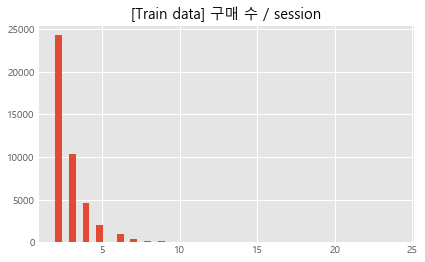

In [11]:
Train_session = train_label.apply(np.sum, axis=1)
Test_session = test_label.apply(np.sum, axis=1)

plt.hist(Train_session, 50)
plt.title(u'[Train data] 구매 수 / session')
plt.show()

In [12]:
Train_session.agg(['min','max','mean'])

min      2.000000
max     24.000000
mean     2.799517
dtype: float64

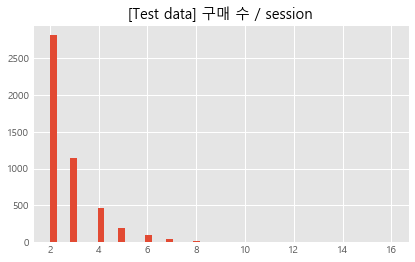

In [13]:
plt.hist(Test_session, 50)
plt.title(u'[Test data] 구매 수 / session')
plt.show()

In [14]:
Test_session.agg(['min','max','mean'])

min      2.000000
max     16.000000
mean     2.740029
dtype: float64

In [15]:
# train에서 가장 많이 구매된 상품
train_label_Rating = train_label.apply(np.sum, axis = 0)
train_label_Rating = pd.DataFrame(train_label_Rating)
train_label_Rating.nlargest(15, 0)

,0
여성티셔츠/탑,4773
남성티셔츠,4558
여성원피스,4329
여성남방셔츠,3946
여성바지,3391
남성캐주얼바지,2579
여성스커트,1845
여아티셔츠/탑,1737
영유아티셔츠/탑,1463
기타일반문구/사무용품,1340


# Doc2Vec

### Doc2Vec 설명

- 임베딩 : 원시 데이터(raw data)를 학습 후 축소된 숫자 목록으로 변환
- Doc2Vec
    

In [16]:
train_data = train_data[['CLNT_ID','SESS_ID','CLAC3_NM']]
test_data = test_data[['CLNT_ID','SESS_ID','CLAC3_NM']]

In [17]:
train_docs = [(str(row['CLAC3_NM']).split(), row['CLNT_ID']) for idx, row in train_data.iterrows()]
test_docs = [(str(row['CLAC3_NM']).split(), row['CLNT_ID']) for idx, row in test_data.iterrows()]

In [18]:
TaggedDocument = namedtuple('TaggedDocument', 'words tags')
tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]
tagged_test_docs = [TaggedDocument(d, [c]) for d, c in test_docs]

In [19]:
cores = multiprocessing.cpu_count()
if True:
    doc_vectorizer = Doc2Vec(dm = 0,
                             dbow_words = 0,
                             seed=1,
                             sample=1e-5,
                             size=300,
                             window=8,
                             min_count=3,
                             workers=cores,
                             alpha=0.025,
                             min_alpha=0.025,
                             iter=20,
                             hs = 1)
    
    doc_vectorizer.build_vocab(tagged_train_docs)
    print(str(doc_vectorizer))
    doc_vectorizer.train(tagged_train_docs,epochs=doc_vectorizer.iter,total_examples=doc_vectorizer.corpus_count)
    

# To save
    doc_vectorizer.save('./doc2vec/doc2model')

Doc2Vec(dbow,d300,n5,hs,mc3,s1e-05,t8)


In [20]:
# To load
# doc_vectorizer = Doc2Vec.load('./doc2vec/doc2model')

In [21]:
train_item = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_train_docs]
train_item_pd = pd.DataFrame(train_item)
train_item_pd.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,0.001249,-0.000702,-0.001365,0.001318,-0.000157,-0.001445,0.000367,0.000453,0.001599,-0.001219,-0.001211,-0.001024,0.001422,-0.001131,0.000276,-0.001594,-0.000239,0.001235,0.000338,0.000796,0.001097,-0.001232,-0.001162,-0.000318,-0.000095,-0.000711,-0.000236,-0.001072,-0.000978,0.000596,0.001637,0.000849,0.001545,0.001258,0.001632,0.000499,-0.000131,0.000448,-0.000895,0.000748,-0.001310,0.001167,-0.001317,0.000522,0.000073,-0.001041,-0.001282,-0.000792,-0.000234,-0.000415,0.001492,0.000180,0.000725,0.001085,-0.000671,-0.000434,-0.001051,-0.001223,-0.000409,-0.001592,-0.000472,0.001645,-0.001642,0.000201,0.001228,0.001626,-0.001266,-0.001307,0.001390,0.000978,-0.000741,0.000932,0.000361,-0.000089,0.001358,-0.001377,0.001401,0.000907,0.001122,-0.000512,0.000319,-0.000503,-0.000213,0.000671,-0.000512,-0.000726,0.000333,0.001248,0.000973,-0.001176,-0.001382,0.000698,-0.000870,-0.001205,-0.000252,0.000551,0.001162,0.001022,-0.001170,-0.000083,0.001226,0.000274,0.001575,0.000927,0.000477,-0.000524,-0.000460,-0.001006,0.001310,0.001559,0.001503,0.001239,0.001369,0.000293,-0.001306,0.000297,-0.000148,-0.000370,-0.000491,0.000193,0.000006,-0.000892,-0.000344,-0.001526,0.000304,0.000455,0.001606,-0.000351,-0.001414,-0.000334,-0.000585,0.000271,0.001627,0.001494,-0.000372,0.000496,0.001065,-0.001063,-0.000355,-0.000924,-0.000916,0.000517,0.001482,0.000435,-0.000999,0.000410,-0.000332,-0.001452,0.000412,0.001383,-0.001531,-0.001068,-0.000159,-0.000451,-0.001165,0.001502,-0.001511,0.000333,-0.001642,0.000109,0.000262,-0.000413,0.000322,0.001220,0.001604,-0.001549,-0.000509,-0.000838,-0.000282,0.000598,-0.001025,0.000280,0.001265,-0.000262,0.001115,-0.000875,-0.000321,0.001658,0.000844,-0.000955,0.001455,0.000617,0.000902,-0.001218,-0.000069,0.001356,-0.001202,-0.000511,0.001527,0.000760,-0.000241,-0.001662,0.001115,-0.000903,0.000260,-0.000939,-0.001449,0.000960,-0.001242,0.001292,0.000630,0.000044,0.001326,0.001418,0.001569,0.001032,-0.000968,0.000397,-0.001236,0.000690,0.000364,-0.001569,0.001057,0.001402,-0.000305,-0.001546,-0.000361,-0.001029,0.001534,0.000620,0.000033,0.000832,-0.000127,-0.000917,0.001159,-0.001256,-0.000019,-0.000166,-0.001184,0.001355,-0.001493,0.001633,-0.000104,-0.000493,0.000878,-0.000218,-0.000051,0.001084,-0.000964,-0.000438,-0.001052,-0.001262,0.001226,0.000748,-0.001394,-0.000684,0.001063,0.001296,-0.001495,0.001150,0.000766,0.000814,0.000722,0.001334,0.000455,-0.001427,-0.000351,-0.000965,-0.001548,-0.001119,0.001298,0.000071,-0.000671,0.000758,-0.000897,-0.001129,-0.001142,0.000682,0.000822,0.000728,0.001115,0.000175,-0.000795,0.000785,-0.000805,0.001548,0.000482,0.000624,-0.000436,-0.000627,-0.001488,0.000021,-0.000689,-0.000365,-0.001401,0.001591,-0.001239,0.000253,0.001086,0.000988,-0.000201,0.000998,0.001237,0.000086,-0.000733,0.001159,0.000199,-0.001434,-0.001040,0.000972
1,-0.001477,0.000030,-0.001531,0.000475,0.001548,-0.001320,

In [22]:
test_item = [doc_vectorizer.infer_vector(doc.words) for doc in tagged_test_docs]
test_item_pd = pd.DataFrame(test_item)
test_item_pd.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
0,-0.001643,0.000456,-0.001661,-0.000255,-0.001123,-0.000310,-0.001341,0.001257,-0.000961,-0.001285,-0.001283,-0.001059,-0.000016,-0.000515,-0.001569,-0.000878,0.000518,0.001082,-0.000245,0.001591,0.001496,-0.000146,0.001317,-0.000755,0.001561,0.001572,-0.001438,-0.000570,0.001045,-0.000575,-0.001393,-0.000086,-0.001409,-0.001192,-0.000528,-0.001544,0.000002,-0.001098,-0.001181,-0.000404,-0.000716,-0.000165,-0.001305,0.000211,-0.001534,0.000782,-0.000950,-0.000639,0.000533,-0.001163,-0.000555,0.000731,0.000938,-0.000527,-0.000864,0.001599,0.000161,0.000879,0.001525,0.000792,0.000948,-0.001330,0.000456,-0.001458,-0.000686,-0.000918,-0.000882,-0.001292,0.001004,0.000321,0.000407,0.000691,-0.001299,-0.001352,0.001010,-0.001142,-0.000736,0.000766,-0.001180,0.000682,-0.000379,-0.000920,0.001457,0.000068,-0.001313,-0.000069,-0.000296,0.001580,0.001358,0.000512,-0.001577,-0.000109,0.000860,-0.001248,0.000428,-0.000385,-0.000030,-0.000825,0.000028,0.000471,-0.000608,-0.001618,-0.000573,-0.000985,-0.001244,0.000245,0.000430,0.000073,0.000315,0.001492,0.000797,-0.001075,0.000834,0.001437,-0.001640,0.001205,0.000668,-0.001403,0.000710,-0.000470,0.000123,-0.000124,0.001323,0.001460,-0.000993,0.000677,-0.001102,-0.000443,0.000880,-0.000880,0.001425,-0.000739,0.000641,-0.000310,-0.000840,0.001181,0.000776,-0.001448,0.000435,0.001303,0.001362,-0.000761,0.000515,0.000551,0.001219,-0.001196,0.000464,0.001548,0.000174,0.001413,-0.000466,-0.001271,3.359785e-04,-0.000515,-0.001333,0.000188,0.001444,-0.001618,0.000034,0.001579,0.001617,0.000210,0.001562,-0.000527,0.000266,0.001204,-0.000403,-0.001445,-0.000088,-0.001506,0.000901,0.001126,-0.000823,0.001432,0.001173,-8.543309e-07,0.001203,0.000075,0.000689,-0.001326,-0.000935,-0.000030,0.000358,-0.000349,-0.000386,0.000586,-0.001289,0.000879,-0.001228,0.000565,-0.000509,-0.000618,-0.000338,0.000736,-0.001056,-0.000187,-0.001585,-0.001456,-0.001215,-0.000407,-0.000044,-6.551880e-07,0.001218,-0.001101,-3.219586e-04,0.001446,0.000754,-0.000176,0.000941,-0.001509,0.000616,0.001184,0.000915,0.000789,-0.000208,0.000184,-0.000061,0.000755,-0.000844,0.001274,-0.000924,0.001319,0.001191,-0.000988,0.000277,-0.001275,0.001100,0.000299,0.001054,0.000912,0.001026,-0.000695,-0.000985,0.000154,-0.000321,-0.000582,-0.000455,-0.000308,-0.000872,-0.000230,-0.000030,-0.000773,0.001538,0.000673,0.000151,-0.001367,0.000109,-0.000995,-0.000912,-0.000885,0.000344,-0.000236,0.001249,0.001150,0.001026,0.001514,-0.000190,0.000963,0.001237,0.000416,0.000968,0.001520,-0.000842,0.000470,0.001080,-0.000381,0.000805,0.000277,-0.000624,-0.001167,-0.000514,4.946067e-04,-0.000614,-0.000412,0.000967,-0.000980,0.000075,0.001382,-0.000213,-0.000581,-0.001216,-0.000611,-0.000134,0.000650,-0.000560,0.001529,0.001417,0.001235,0.001320,-0.000413,0.000709,-0.000066,0.000724,-0.000934,0.000148,-0.000212,-0.000990,-0.000905,0.001025,-0.001362
1,-0.001077,-0.000493,0.00020

## Wide & Deep learning

### Wide & Deep learning 설명

#### Wide input

In [23]:
le = LabelEncoder()

In [24]:
cross_col =[]
for i in range(36):
    for j in range(36-i):
        cross_col.append([train_Segment.columns[i], train_Segment.columns[i + j + 1]])

In [25]:
len(cross_col)

666

In [26]:
train_item_pd_ = cp.deepcopy(train_item_pd)
test_item_pd_ = cp.deepcopy(test_item_pd)
train_Segment_ = cp.deepcopy(train_Segment)
test_Segment_ = cp.deepcopy(test_Segment)

train_Segment_str = train_Segment_.astype(str)
test_Segment_str = test_Segment_.astype(str)

In [27]:
train_wide_ = pd.concat([train_item_pd_, train_Segment_str], axis=1)
test_wide_ = pd.concat([test_item_pd_, test_Segment_str], axis=1)

In [28]:
def cross_columns(data, cross_colnames):
    for i in cross_colnames:
        tmp = 0
        for j in i:
            tmp += 1
            if tmp == 1:
                cross_data = data[j]
                columns = j
            else:
                cross_data = cross_data + data[j]
                columns = columns + "+" + j
        data[columns] = cross_data
        
    return data

In [29]:
wide_cross = cross_columns(train_wide_, cross_col)
wide_cross_test = cross_columns(test_wide_, cross_col)
wide_cross.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,CLAC1_NM_가구,CLAC1_NM_건강식품,CLAC1_NM_계절가전,CLAC1_NM_과일,CLAC1_NM_구기/필드스포츠,CLAC1_NM_남성의류,CLAC1_NM_냉동식품,CLAC1_NM_냉장/세탁가전,CLAC1_NM_냉장식품,CLAC1_NM_모바일,CLAC1_NM_문구/사무용품,CLAC1_NM_상품권,CLAC1_NM_생활/주방가전,CLAC1_NM_세제/위생,CLAC1_NM_속옷/양말/홈웨어,CLAC1_NM_스포츠패션,CLAC1_NM_시즌스포츠,CLAC1_NM_식기/조리기구,CLAC1_NM_아웃도어/레저,CLAC1_NM_여성의류,CLAC1_NM_영상/음향가전,CLAC1_NM_완구,CLAC1_NM_원예/애완,CLAC1_NM_유아동의류,CLAC1_NM_음료,CLAC1_NM_인테리어/조명,CLAC1_NM_자동차용품,CLAC1_NM_주방잡화,CLAC1_NM_청소/세탁/욕실용품,CLAC1_NM_축산물,CLAC1_NM_출산/육아용품,CLAC1_NM_침구/수예,CLAC1_NM_컴퓨터,CLAC1_NM_패션잡화,CLAC1_NM_퍼스널케어,CLAC1_NM_헬스/피트니스,CLAC1_NM_화장품/뷰티케어,CLAC1_NM_가구+CLAC1_NM_건강식품,CLAC1_NM_가구+CLAC1_NM_계절가전,CLAC1_NM_가구+CLAC1_NM_과일,CLAC1_NM_가구+CLAC1_NM_구기/필드스포츠,CLAC1_NM_가구+CLAC1_NM_남성의류,CLAC1_NM_가구+CLAC1_NM_냉동식품,CLAC1_NM_가구+CLAC1_NM_냉장/세탁가전,CLAC1_NM_가구+CLAC1_NM_냉장식품,CLAC1_NM_가구+CLAC1_NM_모바일,CLAC1_NM_가구+CLAC1_NM_문구/사무용품,CLAC1_NM_가구+CLAC1_NM_상품권,CLAC1_NM_가구+CLAC1_NM_생활/주방가전,CLAC1_NM_가구+CLAC1_NM_세제/위생,CLAC1_NM_가구+CLAC1_NM_속옷/양말/홈웨어,CLAC1_NM_가구+CLAC1_NM_스포츠패션,CLAC1_NM_가구+CLAC1_NM_시즌스포츠,CLAC1_NM_가구+CLAC1_NM_식기/조리기구,CLAC1_NM_가구+CLAC1_NM_아웃도어/레저,CLAC1_NM_가구+CLAC1_NM_여성의류,CLAC1_NM_가구+CLAC1_NM_영상/음향가전,CLAC1_NM_가구+CLAC1_NM_완구,CLAC1_NM_가구+CLAC1_NM_원예/애완,CLAC1_NM_가구+CLAC1_NM_유아동의류,CLAC1_NM_가구+CLAC1_NM_음료,CLAC1_NM_가구+CLAC1_NM_인테리어/조명,CLAC1_NM_가구+CLAC1_NM_자동차용품,CLAC1_NM_가구+CLAC1_NM_주방잡화,CLAC1_NM_가구+CLAC1_NM_청소/세탁/욕실용품,CLAC1_NM_가구+CLAC1_NM_축산물,CLAC1_NM_가구+CLAC1_NM_출산/육아용품,CLAC1_NM_가구+CLAC1_NM_침구/수예,CLAC1_NM_가구+CLAC1_NM_컴퓨터,CLAC1_NM_가구+CLAC1_NM_패션잡화,CLAC1_NM_가구+CLAC1_NM_퍼스널케어,CLAC1_NM_가구+CLAC1_NM_헬스/피트니스,CLAC1_NM_가구+CLAC1_NM_화장품/뷰티케어,CLAC1_NM_건강식품+CLAC1_NM_계절가전,CLAC1_NM_건강식품+CLAC1_NM_과일,CLAC1_NM_건강식품+CLAC1_NM_구기/필드스포츠,CLAC1_NM_건강식품+CLAC1_NM_남성의류,CLAC1_NM_건강식품+CLAC1_NM_냉동식품,CLAC1_NM_건강식품+CLAC1_NM_냉장/세탁가전,CLAC1_NM_건강식품+CLAC1_NM_냉장식품,CLAC1_NM_건강식품+CLAC1_NM_모바일,CLAC1_NM_건강식품+CLAC1_NM_문구/사무용품,CLAC1_NM_건강식품+CLAC1_NM_상품권,CLAC1_NM_건강식품+CLAC1_NM_생활/주방가전,CLAC1_NM_건강식품+CLAC1_NM_세제/위생,CLAC1_NM_건강식품+CLAC1_NM_속옷/양말/홈웨어,CLAC1_NM_건강식품+CLAC1_NM_스포츠패션,CLAC1_NM_건강식품+CLAC1_NM_시즌스포츠,CLAC1_NM_건강식품+CLAC1_NM_식기/조리기구,CLAC1_NM_건강식품+CLAC1_NM_아웃도어/레저,CLAC1_NM_건강식품+CLAC1_NM_여성의류,CLAC1_NM_건강식품+CLAC1_NM_영상/음향가전,CLAC1_NM_건강식품+CLAC1_NM_완구,CLAC1_NM_건강식품+CLAC1_NM_원예/애완,CLAC1_NM_건강식품+CLAC1_NM_유아동의류,CLAC1_NM_건강식품+CLAC1_NM_음료,CLAC1_NM_건강식품+CLAC1_NM_인테리어/조명,CLAC1_NM_건강식품+CLAC1_NM_자동차용품,CLAC1_NM_건강식품+CLAC1_NM_주방잡화,CLAC1_NM_건강식품+CLAC1_NM_청소/세탁/욕실용품,CLAC1_NM_건강식품+CLAC1_NM_축산물,CLAC1_NM_건강식품+CLAC1_NM_출산/육아용품,CLAC1_NM_건강식품+CLAC1_NM_침구/수예,CLAC1_NM_건강식품+CLAC1_NM_컴퓨터,CLAC1_NM_건강식품+CLAC1_NM_패션잡화,CLAC1_NM_건강식품+CLAC1_NM_퍼스널케어,CLAC1_NM_건강식품+CLAC1_NM_헬스/피트니스,CLAC1_NM_건강식품+CLAC1_NM_화장품/뷰티케어,CLAC1_NM_계절가전+CLAC1_NM_과일,CLAC1_NM_계절가전+CLAC1_NM_구기/필드스포츠,CLAC1_NM_계절가전+CLAC1_NM_남성의류,CLAC1_NM_계절가전+CLAC1_NM_냉동식품,CLAC1_NM_계절가전+CLAC1_NM_냉장/세탁가전,CLAC1_NM_계절가전+CLAC1_NM_냉장식품,CLAC1_NM_계절가전+CLAC1_NM_모바일,CLAC1_NM_계절가전+CLAC1_NM_문구/사무용품,CLAC1_NM_계절가전+CLAC1_NM_상품권,CLAC1_NM_계절가전+CLAC1_NM_생활/주방가전,CLAC1_NM_계절가전+CLAC1_NM_세제/위생,CLAC1_NM_계절가전+CLAC1_NM_속옷/양

In [30]:
wide_cross_ = pd.concat([wide_cross, wide_cross_test])

In [31]:
wide_cross_.shape

(47890, 1003)

In [32]:
Wide_data_ = pd.get_dummies(wide_cross_)
Wide_data_.head()

0         1         2         3         4         5         6  \
0  0.001249 -0.000702 -0.001365  0.001318 -0.000157 -0.001445  0.000367   
1 -0.001477  0.000030 -0.001531  0.000475  0.001548 -0.001320 -0.001112   
2  0.000908  0.001542  0.000906  0.001374 -0.000589  0.001402  0.001416   
3  0.000206 -0.001220  0.000776 -0.000970  0.000734 -0.001239 -0.001623   
4  0.000370 -0.001591 -0.001117 -0.000911 -0.000856 -0.000411  0.001378   

          7         8         9        10        11        12        13  \
0  0.000453  0.001599 -0.001219 -0.001211 -0.001024  0.001422 -0.001131   
1  0.000317  0.000789 -0.000439 -0.000220  0.000156  0.000221  0.000959   
2 -0.000760 -0.000068 -0.000690  0.000037 -0.000578  0.001549  0.000379   
3  0.000847  0.000383  0.000347 -0.000682  0.000066 -0.000904 -0.001422   
4 -0.000918 -0.000311 -0.000440  0.000247  0.001335 -0.000961 -0.000714   

         14        15        16        17        18        19        20  \
0  0.000276 -0.001594 -0.000239  0.001235  0.000338  0.000796  0.001097   
1  0.000730  0.001320 -0.001547 -0.000040  0.000662  0.000620  0.001627   
2 -0.001315 -0.001316 -0.000382  0.000277  0.000881 -0.000413 -0.001122   
3  0.000649 -0.000719  0.000222  0.000836 -0.000606  0.000721 -0.001244   
4  0.000982 -0.000946  0.000457 -0.000325  0.000556  0.000126 -0.000976   

         21        22        23        24        25        26        27  \
0 -0.001232 -0.001162 -0.000318 -0.000095 -0.000711 -0.000236 -0.001072   
1  0.000030  0.000758  0.001521  0.000971  0.000261 -0.000599  0.000003   
2  0.000231 -0.001441 -0.001519 -0.001408  0.000934 -0.001655 -0.000252   
3 -0.001490  0.001418 -0.000983  0.001352  0.000279  0.001319 -0.000012   
4 -0.000013 -0.000094 -0.000113  0.001344  0.000197 -0.000534 -0.000549   

         28        29        30        31        32        33        34  \
0 -0.000978  0.000596  0.001637  0.000849  0.001545  0.001258  0.001632   
1  0.001540  0.000132 -0.001522  0.000769  0.000112 -0.000872  0.000973   
2  0.001417 -0.000951  0.000349 -0.000637  0.001487  0.000097 -0.000297   
3 -0.001613 -0.000682  0.000795 -0.000807  0.000570  0.000770  0.001080   
4  0.001179  0.001029  0.000661 -0.000482 -0.000738 -0.001339  0.000520   

         35        36        37        38        39        40        41  \
0  0.000499 -0.000131  0.000448 -0.000895  0.000748 -0.001310  0.001167   
1 -0.001312  0.000846 -0.001140 -0.000338 -0.000292  0.001026  0.000050   
2 -0.000167  0.000424 -0.000778 -0.001416  0.000648  0.000298  0.001552   
3 -0.001392 -0.000693 -0.000602  0.000940 -0.000502  0.000377  0.000224   
4 -0.000737 -0.001174  0.000448  0.001226  0.000340 -0.001510 -0.000962   

         42        43        44        45        46        47        48  \
0 -0.001317  0.000522  0.000073 -0.001041 -0.001282 -0.000792 -0.000234   
1 -0.000778  0.000007  0.001301  0.000423 -0.001408 -0.000360 -0.000221   
2  0.000162  0.001148 -0.000646 -0.000524 -0.000763 -0.000315  0.001629   
3  0.001259 -0.001197 -0.001489  0.000405  0.001044  0.000192 -0.001178   
4  0.000086  0.001623 -0.001179  0.001613 -0.000554 -0.000242  0.000379   

         49        50        51        52        53        54        55  \
0 -0.000415  0.001492  0.000180  0.000725  0.001085 -0.000671 -0.000434   
1  0.000908  0.000891  0.000203  0.000972  0.000620 -0.000734  0.000161   
2 -0.000136  0.000736 -0.000004 -0.001342  0.000152 -0.000343  0.000218   
3 -0.000626  0.000799 -0.000169 -0.000837 -0.000974  0.001390 -0.000127   
4  0.001040 -0.001613  0.001297 -0.000540 -0.000309 -0.000036 -0.000819   

         56        57        58        59        60        61        62  \
0 -0.001051 -0.001223 -0.000409 -0.001592 -0.000472  0.001645 -0.001642   
1 -0.001561 -0.001048 -0.001503  0.001535 -0.001374  0.001360 -0.000125   
2 -0.000239 -0.000191 -0.000841  0.000437  0.001302  0.000256 -0.001589   
3 -0.000154 -0.000328 -0.000679 -0.001334 -0.001132  0.000446 -0.001550   
4 -0.000125  0.001490  0.00

In [33]:
Wide_data = Wide_data_[:train_data.shape[0]]
Wide_data_test = Wide_data_[train_data.shape[0]:].reset_index(drop=True)

#### Deep input

- 클릭으로 구매했는지, 검색을해서 구매했는지 확인가능
- 자주사용하는 Device
- 거주지역

In [34]:
user_features = pd.concat([train_user_features, test_user_features])

In [35]:
user_features["CLNT_GENDER"] = le.fit_transform(user_features["CLNT_GENDER"])
user_features["CLNT_AGE"] = le.fit_transform(user_features["CLNT_AGE"])
# user_features["DVC_CTG_NM_y"] = le.fit_transform(user_features["DVC_CTG_NM_y"])
# user_features["ZON_NM_y"] = le.fit_transform(user_features["ZON_NM_y"])
user_features.head()

,CLNT_GENDER,CLNT_AGE
0,0,3
1,0,3
2,0,3
3,0,3
4,0,3


In [36]:
user_features_ = cp.deepcopy(user_features)

In [37]:
train_user_features.shape[0]

43101

In [38]:
user_features = user_features[:train_user_features.shape[0]]

In [39]:
Deep_data = pd.DataFrame(pd.concat([train_item_pd, train_Segment, user_features],
                                   axis=1, join_axes=[train_item_pd.index]))
Deep_col = Deep_data.columns
Deep_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,CLAC1_NM_가구,CLAC1_NM_건강식품,CLAC1_NM_계절가전,CLAC1_NM_과일,CLAC1_NM_구기/필드스포츠,CLAC1_NM_남성의류,CLAC1_NM_냉동식품,CLAC1_NM_냉장/세탁가전,CLAC1_NM_냉장식품,CLAC1_NM_모바일,CLAC1_NM_문구/사무용품,CLAC1_NM_상품권,CLAC1_NM_생활/주방가전,CLAC1_NM_세제/위생,CLAC1_NM_속옷/양말/홈웨어,CLAC1_NM_스포츠패션,CLAC1_NM_시즌스포츠,CLAC1_NM_식기/조리기구,CLAC1_NM_아웃도어/레저,CLAC1_NM_여성의류,CLAC1_NM_영상/음향가전,CLAC1_NM_완구,CLAC1_NM_원예/애완,CLAC1_NM_유아동의류,CLAC1_NM_음료,CLAC1_NM_인테리어/조명,CLAC1_NM_자동차용품,CLAC1_NM_주방잡화,CLAC1_NM_청소/세탁/욕실용품,CLAC1_NM_축산물,CLAC1_NM_출산/육아용품,CLAC1_NM_침구/수예,CLAC1_NM_컴퓨터,CLAC1_NM_패션잡화,CLAC1_NM_퍼스널케어,CLAC1_NM_헬스/피트니스,CLAC1_NM_화장품/뷰티케어,CLNT_GENDER,CLNT_AGE
0,0.001249,-0.000702,-0.001365,0.001318,-0.000157,-0.001445,0.000367,0.000453,0.001599,-0.001219,-0.001211,-0.001024,0.001422,-0.001131,0.000276,-0.001594,-0.000239,0.001235,0.000338,0.000796,0.001097,-0.001232,-0.001162,-0.000318,-0.000095,-0.000711,-0.000236,-0.001072,-0.000978,0.000596,0.001637,0.000849,0.001545,0.001258,0.001632,0.000499,-0.000131,0.000448,-0.000895,0.000748,-0.001310,0.001167,-0.001317,0.000522,0.000073,-0.001041,-0.001282,-0.000792,-0.000234,-0.000415,0.001492,0.000180,0.000725,0.001085,-0.000671,-0.000434,-0.001051,-0.001223,-0.000409,-0.001592,-0.000472,0.001645,-0.001642,0.000201,0.001228,0.001626,-0.001266,-0.001307,0.001390,0.000978,-0.000741,0.000932,0.000361,-0.000089,0.001358,-0.001377,0.001401,0.000907,0.001122,-0.000512,0.000319,-0.000503,-0.000213,0.000671,-0.000512,-0.000726,0.000333,0.001248,0.000973,-0.001176,-0.001382,0.000698,-0.000870,-0.001205,-0.000252,0.000551,0.001162,0.001022,-0.001170,-0.000083,0.001226,0.000274,0.001575,0.000927,0.000477,-0.000524,-0.000460,-0.001006,0.001310,0.001559,0.001503,0.001239,0.001369,0.000293,-0.001306,0.000297,-0.000148,-0.000370,-0.000491,0.000193,0.000006,-0.000892,-0.000344,-0.001526,0.000304,0.000455,0.001606,-0.000351,-0.001414,-0.000334,-0.000585,0.000271,0.001627,0.001494,-0.000372,0.000496,0.001065,-0.001063,-0.000355,-0.000924,-0.000916,0.000517,0.001482,0.000435,-0.000999,0.000410,-0.000332,-0.001452,0.000412,0.001383,-0.001531,-0.001068,-0.000159,-0.000451,-0.001165,0.001502,-0.001511,0.000333,-0.001642,0.000109,0.000262,-0.000413,0.000322,0.001220,0.001604,-0.001549,-0.000509,-0.000838,-0.000282,0.000598,-0.001025,0.000280,0.001265,-0.000262,0.001115,-0.000875,-0.000321,0.001658,0.000844,-0.000955,0.001455,0.000617,0.000902,-0.001218,-0.000069,0.001356,-0.001202,-0.000511,0.001527,0.000760,-0.000241,-0.001662,0.001115,-0.000903,0.000260,-0.000939,-0.001449,0.000960,-0.001242,0.001292,0.000630,0.000044,0.001326,0.001418,0.001569,0.001032,-0.000968,0.000397,-0.001236,0.000690,0.000364,-0.001569,0.001057,0.001402,-0.000305,-0.001546,-0.000361,-0.001029,0.001534,0.000620,0.000033,0.000832,-0.000127,-0.000917,0.001159,-0.001256,-0.000019,-0.000166,-0.001184,0.001355,-0.001493,0.001633,-0.000104,-0.000493,0.000878,-0.000218,-0.000051,0.001084,-0.000964,-0.000438,-0.001052,-0.001262,0.001226,0.000748,-0.0013

In [40]:
user_features_ = user_features_[train_user_features.shape[0]:].reset_index(drop=True)

In [41]:
Deep_data_test = pd.DataFrame(pd.concat([test_item_pd, test_Segment, user_features_],
                                   axis=1, join_axes=[test_item_pd.index]))

In [42]:
Deep_data[Deep_col[-2:]].head()

,CLNT_GENDER,CLNT_AGE
0,0,3
1,0,3
2,0,3
3,0,3
4,0,3


In [43]:
# parameters
keep_prob = 0.7
learning_rate = 1e-7
training_epochs = 501
batch_size = 256

wide_size = len(Wide_data.columns)
deep_size = len(Deep_data.columns) 
deep_embed_size = 2 # 임베딩할 컬럼 개수

output_size = len(train_label.columns)

He = tf.contrib.layers.variance_scaling_initializer()

# input place holders
tf.reset_default_graph()
Wide = tf.placeholder(tf.float32, [None, wide_size])
Deep_un_embed = tf.placeholder(tf.float32, [None, deep_size - deep_embed_size])
Deep_embed = tf.placeholder(tf.int32, [None, deep_embed_size])

Y = tf.placeholder(tf.float32, [None, output_size])
train_mode = tf.placeholder(tf.bool, name='train_mode')

In [44]:
no_class_max = 42
embedding_size = 5

deep_embed_var = tf.Variable(tf.random_uniform([no_class_max, embedding_size], -1.0, 1.0))
deep_embed = tf.nn.embedding_lookup(deep_embed_var, Deep_embed)
deep_embed_re = tf.reshape(deep_embed, [-1, embedding_size * deep_embed_size])
Deep = tf.concat([Deep_un_embed, deep_embed_re], axis=1)

In [45]:
Deep

<tf.Tensor 'concat:0' shape=(?, 347) dtype=float32>

In [46]:
deep_size

339

### Wide

In [47]:
A = tf.get_variable("A", shape=[wide_size, output_size])
b = tf.Variable(tf.random_normal([output_size]))

wide = tf.add(tf.matmul(Wide, A), b)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


### Deep

In [48]:
W1 = tf.get_variable("W1", shape=[347, 1024], initializer=He)
b1 = tf.Variable(tf.random_normal([1024]))
L1 = tf.nn.relu(tf.matmul(Deep, W1) + b1)

W2 = tf.get_variable("W2", shape=[1024, 512], initializer=He)
b2 = tf.Variable(tf.random_normal([512]))
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)


W3 = tf.get_variable("W3", shape=[512, 256], initializer=He)
b3 = tf.Variable(tf.random_normal([256]))
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)

W4 = tf.get_variable("W4", shape=[256, 128], initializer=He)
b4 = tf.Variable(tf.random_normal([128]))
L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)

W5 = tf.get_variable("W5", shape=[128, output_size], initializer=He)
b5 = tf.Variable(tf.random_normal([output_size]))

deep = tf.add(tf.matmul(L4, W5), b5)

In [49]:
hypothesis = wide + deep

In [50]:
global_step = tf.Variable(initial_value=0, name='global_step', trainable=False)

In [51]:
cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=hypothesis, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost, global_step=global_step)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


#### Session

In [52]:
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
sess.run(tf.global_variables_initializer())

In [53]:
def Model_train(training_epochs = 501):
    for epoch in range(training_epochs):
        avg_cost = 0
        total_batch = int(len(Deep_data) / batch_size)

        for i in range(0, len(Deep_data), batch_size):
            batch_wide = Wide_data[i:i+batch_size]
            batch_deep = Deep_data[i:i+batch_size][Deep_col[:-2]]
            batch_deep_embed = Deep_data[i:i+batch_size][Deep_col[-2:]]
            
            batch_label = train_label[i:i+batch_size]
            

            feed_dict_train = {Wide: batch_wide,
                               Deep_un_embed: batch_deep,
                               Deep_embed: batch_deep_embed,
                               Y: batch_label}
            
            i_global, opt, c = sess.run([global_step, optimizer, cost],
                                        feed_dict=feed_dict_train)

            avg_cost += c/total_batch

        if (epoch % 100 == 0) or (epoch == training_epochs - 1):
            time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            print("[epoch: {:>4}][Cost: {:>.5f}][{}]".format(epoch, avg_cost, time))

#         if (epoch % 10 == 0) or (epoch == training_epochs - 1):
#             saver.save(sess, save_path=save_path, global_step=global_step)
#             print("Saved checkpoint.")
            
    print('Learning Finished!')

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    Model_train()

[epoch:    0][Cost: 0.16782][2019-11-20 17:40:24]
[epoch:  100][Cost: 0.01002][2019-11-20 17:53:34]
[epoch:  200][Cost: 0.00931][2019-11-20 18:06:35]


#### Recommendation

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    YY = tf.equal(Y , 1)
    XX = tf.greater(tf.sigmoid(hypothesis), 0.7)
    correct = tf.equal(XX, YY)

    accuracy = tf.reduce_mean(tf.cast(correct, 'float'))

    feed_dict_test = {Wide: Wide_data_test,
                      Deep_un_embed: Deep_data_test[Deep_col[:-2]],
                      Deep_embed: Deep_data_test[Deep_col[-2:]],
                      Y: test_label}

    print("Accuracy: {:>.5f}".format(sess.run(accuracy, feed_dict=feed_dict_test))) 

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    score = sess.run(tf.sigmoid(hypothesis), feed_dict={Wide: Wide_data_test, 
                                                        Deep_un_embed: Deep_data_test[Deep_col[:-2]],
                                                        Deep_embed: Deep_data_test[Deep_col[-2:]],
#                                                         Deep: Deep_data_test
                                                       })
    score = pd.DataFrame(score, columns=train_label.columns)

In [ ]:
Item_test = pd.read_csv("./doc2vec/Item_test.csv")
test_label['item'] = Item_test['CLAC3_NM']
test_label.to_csv('./doc2vec/test_label_item.csv',index=False)

In [ ]:
test_label.drop('item',axis=1,inplace=True)

In [ ]:
test_label_item = pd.read_csv('./doc2vec/test_label_item.csv')
test_label_item.head()

In [ ]:
score.shape

In [ ]:
score.head()

In [ ]:
def get_acc(score_matrix, top_n, test_matix):
    avg_acc = 0
    for i in range(len(score_matrix)):
        top = score_matrix.iloc[i].nlargest(top_n).index
        tmp = 0
        for j in range(len(top)):
            if top[j] in test_matix["item"][i].split():
                tmp += 1

        acc = tmp / len(top)
        avg_acc += acc / len(score_matrix)

    return avg_acc

In [ ]:
print("Hit rate of Top 3: {:>.5f}".format(get_acc(score, 3, test_label_item)))
print("Hit rate of Top 10: {:>.5f}".format(get_acc(score, 10, test_label_item)))

In [ ]:
def Model_eval(training_epochs = 501):
    for epoch in range(training_epochs):
        avg_cost = 0
        total_batch = int(len(Deep_data) / batch_size)

        for i in range(0, len(Deep_data), batch_size):
            batch_wide = Wide_data[i:i+batch_size]
            batch_deep = Deep_data[i:i+batch_size][Deep_col[:-2]]
            batch_deep_embed = Deep_data[i:i+batch_size][Deep_col[-2:]]
            
            batch_label = train_label[i:i+batch_size]

            feed_dict_train = {Wide: batch_wide,
                               Deep_un_embed: batch_deep,
                               Deep_embed: batch_deep_embed,
                               Y: batch_label}
            
            feed_dict_test = {Wide: Wide_data_test,
                              Deep_un_embed: Deep_data_test[Deep_col[:-2]],
                              Deep_embed: Deep_data_test[Deep_col[-2:]],
                              Y: test_label}
            
            i_global, opt, c = sess.run([global_step, optimizer, cost], feed_dict=feed_dict_train)

            avg_cost += c/total_batch
            
        score = sess.run(tf.sigmoid(hypothesis), feed_dict=feed_dict_test)
        score_pd = pd.DataFrame(score, columns=train_label.columns)
        acc = get_acc(score_pd, 10, test_label_item)

        if (epoch % 100 == 0) or (epoch == training_epochs - 1):
            time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
            main = "[Epoch: {:>4}][Cost: {:>.5f}][Hit rate of Top 10: {:>.5f}]"
            print(main.format(epoch, avg_cost, acc))
#             print("[global_step: {:>4}][{}]".format(i_global, time))

#         if (epoch % 10 == 0) or (epoch == training_epochs - 1):
#             saver.save(sess, save_path=save_path, global_step=global_step)
#             print("Saved checkpoint.")
            
    print('Learning Finished!')

In [ ]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    Model_eval(10)

In [ ]:
print("Hit rate of Top 3: {:>.5f}".format(get_acc(score, 3, test_label_item)))
print("Hit rate of Top 10: {:>.5f}".format(get_acc(score, 10, test_label_item)))

# 추천 상품 비교

In [ ]:
train_docs[105]

In [ ]:
list(score.iloc[105].nlargest(10).index)